# Stochastic oscillator


In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from utils import get_data, get_return_simulation
from strategies import stochastic_oscillator

plt.style.use("seaborn")

In [2]:
weights = [0.5, 0.4, 0.023, 0.033, 0.043]

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

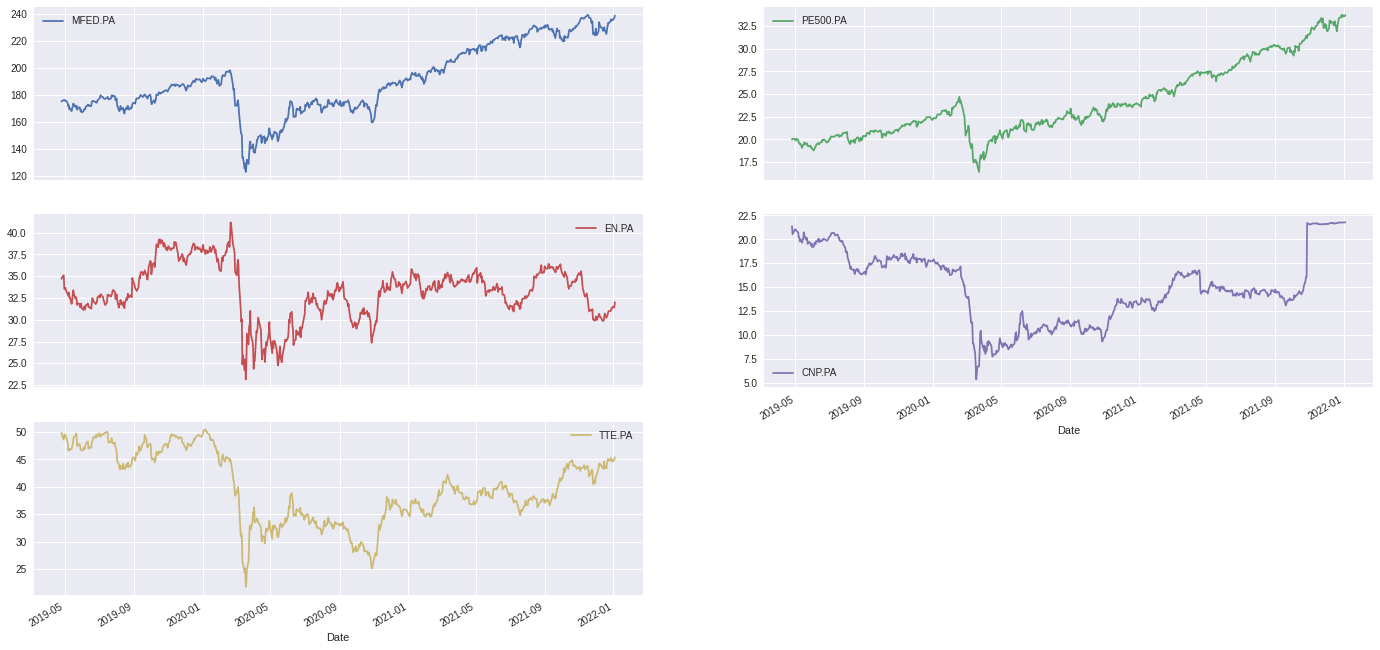

In [3]:
df, stocks = get_data('stocks', columns=["Open", "High", "Low", "Close"])
df = df.dropna()

df['Close'].plot(figsize=(24, 12), subplots=True, layout=(3, 2))

In [4]:
k_period = 14
d_period = 3

n_high = df['High'].rolling(k_period).max()
n_low = df['Low'].rolling(k_period).min()

k = (df['Close'] - n_low) * 100 / (n_high - n_low)
d = k.rolling(d_period).mean()

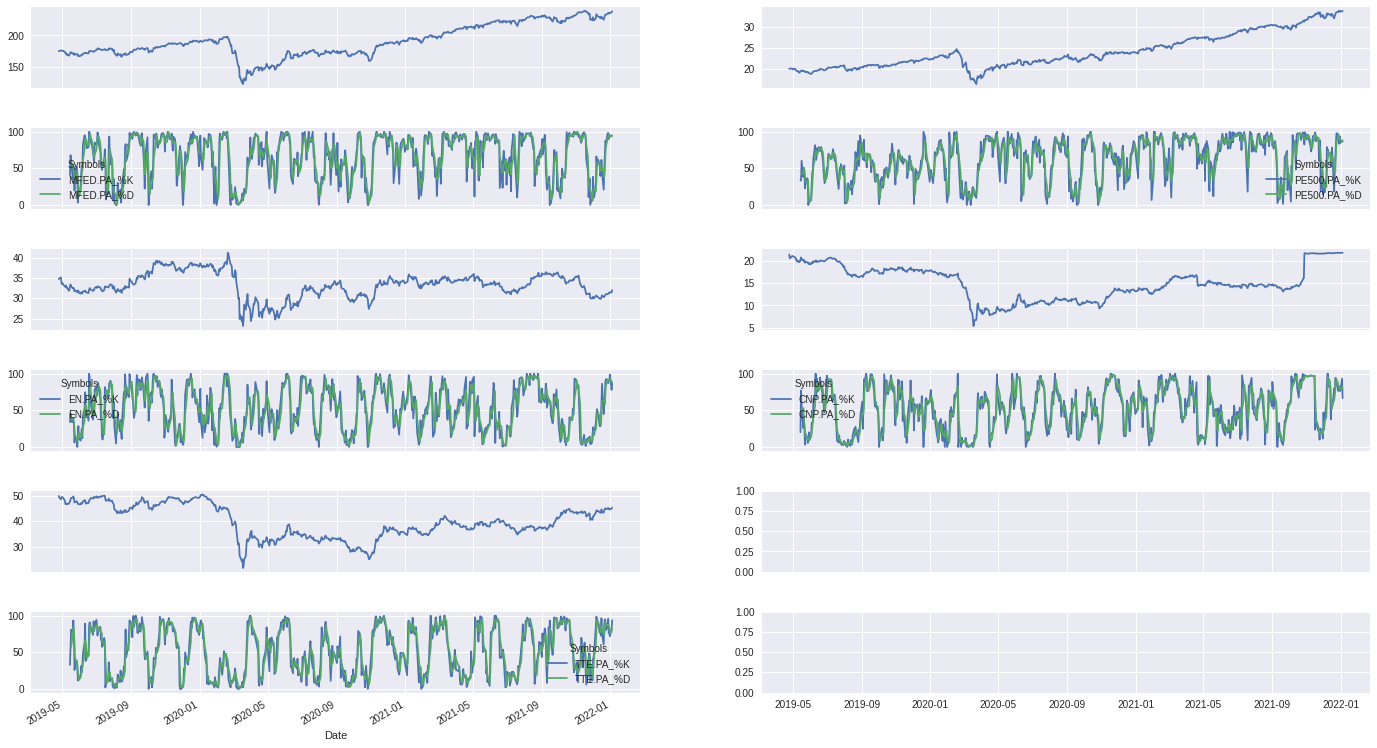

In [5]:
stochastic = pd.concat([
    df['Close'],
    k.add_suffix('_%K'),
    d.add_suffix('_%D')
], axis=1)

fig, axes = plt.subplots(nrows=6, ncols=2, sharex=True)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    stochastic[s].plot(
        figsize=(24, 14), ax=axes[i // 2 * 2, i % 2]
    )
    stochastic[[f"{s}_%K", f"{s}_%D"]].plot(ax=axes[i // 2 * 2 + 1, i % 2])

In [6]:
for s in stocks:
    stochastic[f"{s}_POSITION"] = np.where((stochastic[f"{s}_%K"] < 20) & (stochastic[f"{s}_%D"] < 20) & (stochastic[f"{s}_%K"] > stochastic[f"{s}_%D"]), 1, 0)

    stochastic[f"{s}_TRANSACTIONS"] = stochastic[f"{s}_POSITION"].diff().clip(lower=0)
    stochastic.loc[stochastic.index[0], f"{s}_TRANSACTIONS"] = 1

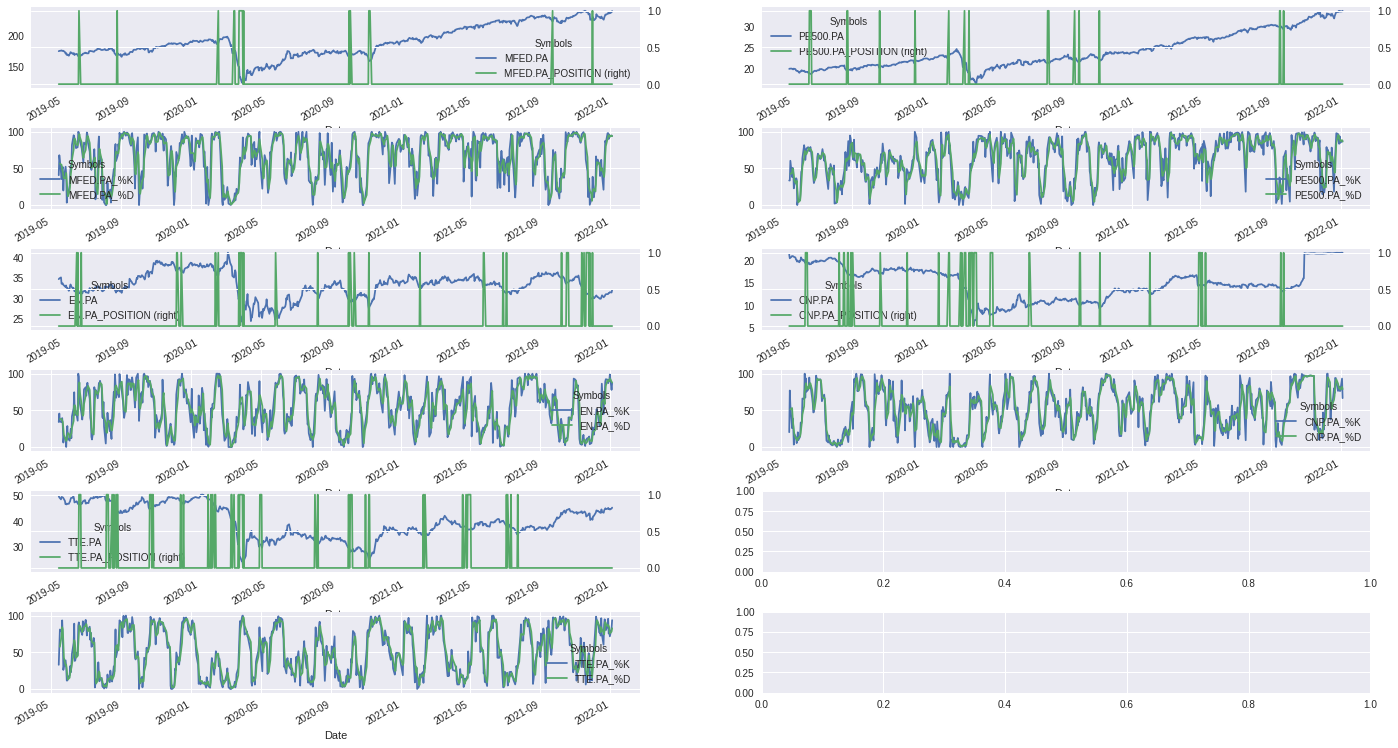

In [7]:
fig, axes = plt.subplots(nrows=6, ncols=2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, s in enumerate(stocks):
    stochastic[[s, f"{s}_POSITION"]].plot(
        figsize=(24, 14), ax=axes[i // 2 * 2, i % 2], secondary_y=f"{s}_POSITION"
    )
    stochastic[[f"{s}_%K", f"{s}_%D"]].plot(ax=axes[i // 2 * 2 + 1, i % 2])

In [8]:
get_return_simulation(stochastic, stocks)

{'MFED.PA': {'base returns': 1.3635583823033623,
  'amount invested': 2087.339988708496,
  'strategy returns': 1.3719853700161881},
 'PE500.PA': {'base returns': 1.6872499465942383,
  'amount invested': 310.82799911499023,
  'strategy returns': 1.5199080726045282},
 'EN.PA': {'base returns': 0.9230546995695109,
  'amount invested': 884.2700004577637,
  'strategy returns': 1.0142150761148088},
 'CNP.PA': {'base returns': 1.0177736708620906,
  'amount invested': 390.8949999809265,
  'strategy returns': 1.5030123337685994},
 'TTE.PA': {'base returns': 0.9091273427844775,
  'amount invested': 1400.974998474121,
  'strategy returns': 1.1658451887626753}}

In [9]:
symbols = stocks[:]
results = pd.DataFrame()


for periods in range(2, 30):
    current_df = stochastic_oscillator(df, symbols, k_period=periods)

    return_simulation = get_return_simulation(current_df, symbols)
    market = sum(
        [w * return_simulation[s]["base returns"] for s, w in zip(symbols, weights)]
    )
    strategy = sum(
        [w * return_simulation[s]["strategy returns"] for s, w in zip(symbols, weights)]
    )

    results = results.append(
        pd.DataFrame(
            {
                "periods": periods,
                "market": market,
                "strategy": strategy,
                "out": strategy - market,
            },
            index=[0],
        ),
        ignore_index=True,
    )

results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   periods   28 non-null     int64  
 1   market    28 non-null     float64
 2   strategy  28 non-null     float64
 3   out       28 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.0 KB


In [10]:
results.sort_values("out", ascending=False).head(10)

,periods,market,strategy,out
27,29,1.450588,1.516914,0.066325
26,28,1.450588,1.516193,0.065604
25,27,1.450588,1.515747,0.065158
24,26,1.450588,1.515317,0.064729
23,25,1.450588,1.507594,0.057006
21,23,1.450588,1.507398,0.056810
22,24,1.450588,1.507112,0.056523
20,22,1.450588,1.489244,0.038656
19,21,1.450588,1.484295,0.033707
15,17,1.450588,1.469352,0.018764


## Conclusion

- stochastic oscillator behaves similar to rsi